Load All JSON Files

In [6]:
import json
import pandas as pd

def load_transaction_type(files, tx_type):
    dfs = []
    for file in files:
        with open(file) as f:
            data = json.load(f)
        if tx_type in data:
            dfs.append(pd.json_normalize(data[tx_type]))
    return pd.concat(dfs, ignore_index=True)

files = ["compoundV2_transactions_ethereum_chunk_2.json", "compoundV2_transactions_ethereum_chunk_0.json", "compoundV2_transactions_ethereum_chunk_1.json"]

# Load each transaction type
df_deposits = load_transaction_type(files, "deposits")
df_borrows = load_transaction_type(files, "borrows")
df_repays = load_transaction_type(files, "repays")
df_withdraws = load_transaction_type(files, "withdraws")
df_liquidates = load_transaction_type(files, "liquidates")


Preprocessing and Renaming Columns

In [7]:
def clean_df(df, action, wallet_field="account.id"):
    df = df.rename(columns={
        wallet_field: "wallet",
        "amountUSD": f"{action}_usd",
        "timestamp": "timestamp"
    })
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", errors='coerce')
    df[f"{action}_usd"] = pd.to_numeric(df[f"{action}_usd"], errors="coerce")
    return df[["wallet", f"{action}_usd", "timestamp"]].dropna()


df_deposits = clean_df(df_deposits, "deposit")
df_borrows = clean_df(df_borrows, "borrow")
df_repays = clean_df(df_repays, "repay")
df_withdraws = clean_df(df_withdraws, "withdraw")
df_liquidates = clean_df(df_liquidates, "liquidation", wallet_field="liquidatee.id")



C:\Users\parth\AppData\Local\Temp\ipykernel_6352\1432019178.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", errors='coerce')
C:\Users\parth\AppData\Local\Temp\ipykernel_6352\1432019178.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", errors='coerce')
C:\Users\parth\AppData\Local\Temp\ipykernel_6352\1432019178.py:7: FutureWarning: The behavior of 'to_datetim

 Rename action columns to a common name for merging

In [8]:
# Rename action columns to a common name for merging
df_deposits = df_deposits.rename(columns={"deposit_usd": "usd", "timestamp": "timestamp", "wallet": "wallet"})
df_borrows = df_borrows.rename(columns={"borrow_usd": "usd"})
df_repays = df_repays.rename(columns={"repay_usd": "usd"})
df_withdraws = df_withdraws.rename(columns={"withdraw_usd": "usd"})
df_liquidates = df_liquidates.rename(columns={"liquidation_usd": "usd"})

# Add action column
df_deposits["action"] = "deposit"
df_borrows["action"] = "borrow"
df_repays["action"] = "repay"
df_withdraws["action"] = "withdraw"
df_liquidates["action"] = "liquidate"

# Combine all
combined_df = pd.concat([
    df_deposits,
    df_borrows,
    df_repays,
    df_withdraws,
    df_liquidates
], ignore_index=True)


Getting summary of wallets

In [9]:
wallet_summary = combined_df.groupby(["wallet", "action"])["usd"].sum().reset_index()
wallet_summary

,wallet,action,usd
0,0x00000000af5a61acaf76190794e3fdf1289288a1,repay,6.256053e+04
1,0x00000000af5a61acaf76190794e3fdf1289288a1,withdraw,2.649560e+04
2,0x00000000b1786c9698c160d78232c78d6f6474fe,repay,2.888216e+04
3,0x000000aaee6a496aaf7b7452518781786313400f,borrow,2.695671e+06
4,0x000000aaee6a496aaf7b7452518781786313400f,deposit,7.708146e+05
...,...,...,...
28803,0xfff93f0af4ef0fecc48071cfaa9fd798cf216165,withdraw,1.231029e+02
28804,0xfff95dea424c0d7a25471982610a2485f302fb54,deposit,6.200050e+01
28805,0xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,borrow,2.876790e+02
28806,0xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,liquidate,4.033772e+00


Getting top Wallets

In [10]:
top_wallets = combined_df.groupby("wallet")["usd"].sum().sort_values(ascending=False).head(10)
top_wallets

wallet
0x37acfef331e6063c8507c2a69c97b4f78c770a5a    7.488912e+07
0x388b93c535b5c3ccdb14770516d7caf5590ed009    7.252060e+07
0x716034c25d9fb4b38c837afe417b7f2b9af3e9ae    6.775487e+07
0xb1adceddb2941033a090dd166a462fe1c2029484    6.623576e+07
0xdf63be2e473ba04c26b1609e51d08cf0d78e0913    6.536593e+07
0xc1852f917835a9f2f97112672bc5c8afd1f21dc3    6.316293e+07
0x586e32930ac05127de429bd566eaa2758fcbd9bc    5.867612e+07
0x909b443761bbd7fbb876ecde71a37e1433f6af6f    5.458294e+07
0x3584ca77ba08bd8b3fe4762e60eb284e37696829    4.810243e+07
0xceef57f6c40a7cb2392eaad101ee0440aa43ba42    4.530714e+07
Name: usd, dtype: float64

Accessing more data

In [11]:
combined_df["date"] = combined_df["timestamp"].dt.date
daily_volume = combined_df.groupby(["date", "action"])["usd"].sum().reset_index()
daily_volume

,date,action,usd
0,2019-05-07,borrow,5.944316e+02
1,2019-05-07,deposit,1.023940e+04
2,2019-05-08,borrow,4.157521e+03
3,2019-05-08,deposit,1.504912e+04
4,2019-05-08,repay,3.155575e+01
...,...,...,...
2477,2025-03-09,liquidate,2.415089e+03
2478,2025-03-10,liquidate,3.338488e+06
2479,2025-03-11,liquidate,1.101110e+06
2480,2025-03-12,liquidate,8.561762e+02


visualizing the transactions

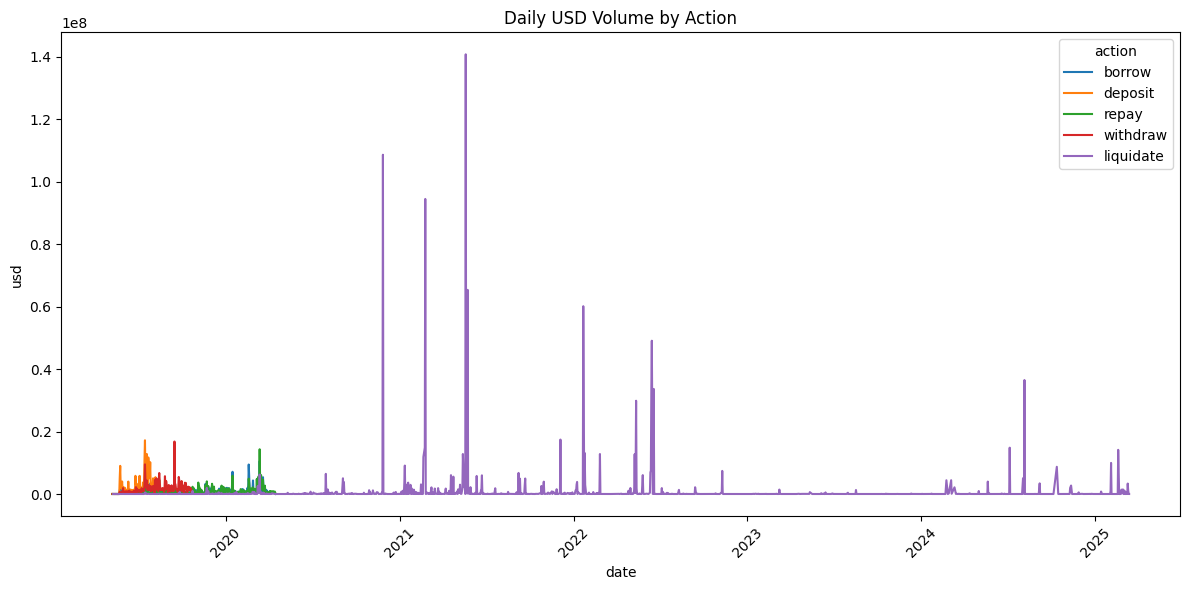

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_volume, x="date", y="usd", hue="action")
plt.title("Daily USD Volume by Action")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Adding 'action' column to each transaction DataFrame

In [ ]:

df_deposits["action"] = "deposit"
df_borrows["action"] = "borrow"
df_repays["action"] = "repay"
df_withdraws["action"] = "withdraw"
df_liquidates["action"] = "liquidation"


Rename USD columns to a common name for merging

In [ ]:

df_deposits = df_deposits.rename(columns={"deposit_usd": "usd"})
df_borrows = df_borrows.rename(columns={"borrow_usd": "usd"})
df_repays = df_repays.rename(columns={"repay_usd": "usd"})
df_withdraws = df_withdraws.rename(columns={"withdraw_usd": "usd"})
df_liquidates = df_liquidates.rename(columns={"liquidation_usd": "usd"})


Combine all transactions into one DataFrame

In [ ]:

combined_df = pd.concat([
    df_deposits,
    df_borrows,
    df_repays,
    df_withdraws,
    df_liquidates
])


Group and pivot by wallet

In [ ]:

wallet_features = combined_df.pivot_table(
    index="wallet",
    columns="action",
    values="usd",
    aggfunc=["count", "sum"],
    fill_value=0
)


Flatten column names for easy access

In [ ]:

wallet_features.columns = ['_'.join(col).strip() for col in wallet_features.columns.values]
wallet_features.reset_index(inplace=True)


Compute ratios to measure behavior

In [ ]:

wallet_features["repay_to_borrow_ratio"] = wallet_features["sum_repay"] / (wallet_features["sum_borrow"] + 1)
wallet_features["deposit_to_withdraw_ratio"] = wallet_features["sum_deposit"] / (wallet_features["sum_withdraw"] + 1)
wallet_features["liquidation_ratio"] = wallet_features["count_liquidation"] / (
    wallet_features["count_borrow"] + wallet_features["count_repay"] + 1
)


Cliping extreme ratios to prevent outliers from affecting scoring

In [ ]:

wallet_features["repay_to_borrow_ratio"] = wallet_features["repay_to_borrow_ratio"].clip(0, 10)
wallet_features["deposit_to_withdraw_ratio"] = wallet_features["deposit_to_withdraw_ratio"].clip(0, 10)
wallet_features["liquidation_ratio"] = wallet_features["liquidation_ratio"].clip(0, 1)


Doing Normalization Using QuantileTransformer

In [21]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='uniform')

wallet_features[["rtb", "dtw", "lr", "sd", "sr"]] = scaler.fit_transform(wallet_features[[
    "repay_to_borrow_ratio",
    "deposit_to_withdraw_ratio",
    "liquidation_ratio",
    "sum_deposit",
    "sum_repay"
]])


Compute custom score using weighted formula

In [ ]:

wallet_features["score"] = (
    25 * wallet_features["rtb"] +
    25 * wallet_features["dtw"] -
    25 * wallet_features["lr"] +
    12.5 * wallet_features["sd"] +
    12.5 * wallet_features["sr"]
)


 Scale score between 0 and 100

In [ ]:

min_score = wallet_features["score"].min()
max_score = wallet_features["score"].max()
wallet_features["normalized_score"] = ((wallet_features["score"] - min_score) / (max_score - min_score)) * 100


Visualize score distribution

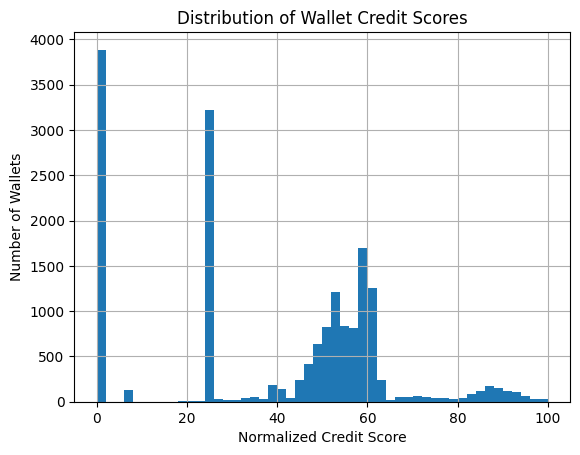

In [ ]:
import matplotlib.pyplot as plt


wallet_features["normalized_score"].hist(bins=50)
plt.title("Distribution of Wallet Credit Scores")
plt.xlabel("Normalized Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


In [25]:
# Get top 1000 wallets by score
top_1000 = wallet_features.sort_values(by="score", ascending=False).head(1000)[["wallet", "normalized_score"]]
top_1000.head(10)


,wallet,normalized_score
4937,0x49b357c9acaa84a0cb978571b642b825e964b2cc,100.000000
3809,0x389135c984febdbb310adaf23a690dc28c8fa62b,99.974744
6739,0x6555e1cc97d3cba6eaddebbcd7ca51d75771e0b8,99.969062
4220,0x3f3e7cd8be447aeb65c05eb6596b03e8c8627803,99.863260
3480,0x339cec7dfec9c95bae4e445e4af87de8c89313cf,99.685149
12697,0xbc0c33fff2888a499a519a641a91f9d7dd270b71,99.604826
4774,0x4758a12fb01dc7cad5741246b9e2eb59ae1ef38b,99.572214
8360,0x7db7da086318462a46327b8f2d46f457008cc111,99.557426
1055,0x0fccef1c29deddb1e2a007ee9c1edf63149aa6b3,99.428216
12721,0xbc77738aa2ede049edac45a8a9a443c5415e6b7a,99.384577


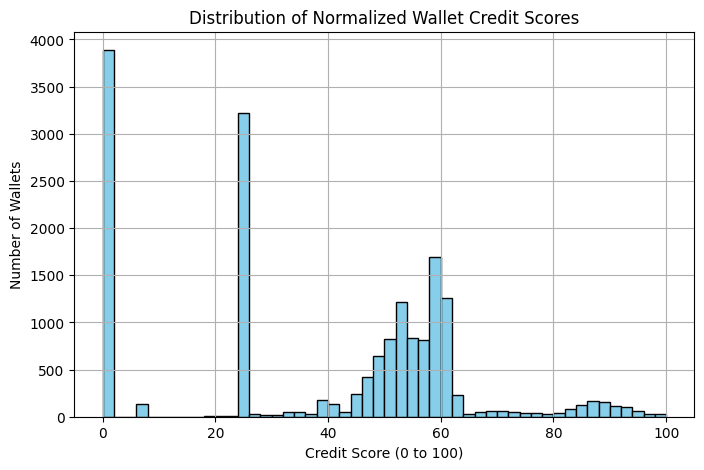

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
wallet_features["normalized_score"].hist(bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Normalized Wallet Credit Scores")
plt.xlabel("Credit Score (0 to 100)")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


checking skewness

In [27]:
from scipy.stats import skew

score_skewness = skew(wallet_features["normalized_score"])
print(f"Skewness of normalized_score: {score_skewness:.4f}")


Skewness of normalized_score: -0.1585


This distribution is very mildly left-skewed, but it’s well within acceptable range for most ML models and analysis tasks 

saving the model using.pkl file for using further

In [29]:
import pickle

# Save the full DataFrame (with normalized_score) or just the model if applicable
with open("wallet_scoring.pkl", "wb") as f:
    pickle.dump(wallet_features, f)
